In [ ]:
import os
import pandas as pd
from glob import glob
from PIL import Image
from google.colab import drive

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Mount Google Drive
drive.mount('/content/drive')

# Base directory
base_path = '/content/drive/MyDrive'
sub_path = 'Advanced Machine Learning/skin disease detection fusion model'
full_path = os.path.join(base_path, sub_path)

# Check folders in directory
print("Folders in path:", os.listdir(full_path))

# Step 1: Gather image paths from multiple folders
image_folders = ['images1', 'images2', 'images3']
image_paths = []
for folder in image_folders:
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths += glob(os.path.join(full_path, folder, ext))

print(f"Found {len(image_paths)} image files.")

# Step 2: Map image file names to their full paths
image_map = {os.path.basename(path): path for path in image_paths}

# Step 3: Load and prepare metadata
df = pd.read_csv(os.path.join(full_path, "cleaned_metadata.csv"))
df['img_path'] = df['img_id'].map(image_map)
# Removes any rows where img_path is NaN
df = df.dropna(subset=['img_path'])
print(df.shape)

Mounted at /content/drive
Folders in path: ['metadata.csv', '.git', 'images1', '.ipynb_checkpoints', 'images2', 'images3', 'scaler_metadata.pkl', 'cleaned_metadata.csv', 'preprocessing.ipynb', 'Replication_of_ADV_Project (1).ipynb', 'Testing_phase_2.ipynb', 'Testing.ipynb', 'only_Encoder.ipynb', 'Full_Autoencoders.ipynb', 'ADV_Project.ipynb']
Found 2298 image files.
(2298, 60)


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'smoke', 'drink', 'age', 'pesticide', 'gender',
       'skin_cancer_history', 'cancer_history', 'has_piped_water',
       'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2',
       'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation',
       'img_id', 'biopsed', 'region_ARM', 'region_BACK', 'region_CHEST',
       'region_EAR', 'region_FACE', 'region_FOOT', 'region_FOREARM',
       'region_HAND', 'region_LIP', 'region_NECK', 'region_NOSE',
       'region_SCALP', 'region_THIGH', 'background_father_BRASIL',
       'background_father_BRAZIL', 'background_father_CZECH',
       'background_father_GERMANY', 'background_father_ISRAEL',
       'background_father_ITALY', 'background_father_NETHERLANDS',
       'background_father_POLAND', 'background_father_POMERANIA',
       'background_father_PORTUGAL', 'background_father_SPAIN',
       'background_father_UNK', 'background_father_Unknown',
       'background_mother_FRANCE', 'background_mother_GE

In [ ]:
print(df['Unnamed: 0'])

0          0
1          1
2          2
3          3
4          4
        ... 
2293    2293
2294    2294
2295    2295
2296    2296
2297    2297
Name: Unnamed: 0, Length: 2298, dtype: int64


In [ ]:
# determine the dimensionality of the feature vector
def get_cnn_output_dim(cnn_model, input_shape=(3, 224, 224)):
    cnn_model.eval()
    with torch.no_grad():
        dummy_input = torch.zeros(1, *input_shape)
        output = cnn_model(dummy_input)
        if output.ndim > 2:
            output = torch.flatten(output, 1)
        return output.shape[1]

In [ ]:
# For testing the get_cnn_output_dim function
from torchvision import models

resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()

dim = get_cnn_output_dim(resnet)
print(dim)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


2048


In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models import vgg19_bn, VGG19_BN_Weights
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Step 4: Define image + metadata dataset
class SkinCancerMultimodalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.meta_features = self.df.drop(columns=['diagnostic','img_id', 'Unnamed: 0', 'img_path'], errors='ignore').astype('float32')
        self.labels = self.df['diagnostic'].astype(int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['img_path']).convert("RGB")
        if self.transform:
            image = self.transform(image)
        metadata = torch.tensor(self.meta_features.iloc[idx].values, dtype=torch.float32)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, metadata, label





In [42]:
# Step 5: Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 6: Load dataset
# dataset = SkinCancerMultimodalDataset(df, transform)


# # EXTRACT metadata features (numerical only!) and label as arrays
# X_meta = df.drop(columns=['diagnostic', 'img_path', 'Unnamed: 0', 'img_id'], errors='ignore').values.astype(np.float32)
# y = df['diagnostic'].values.astype(np.int64)
# img_paths = df['img_path'].values



# # Split
# from sklearn.model_selection import train_test_split
# X_meta_train, X_meta_val, y_train, y_val, img_train, img_val = train_test_split(
#     X_meta, y, img_paths, test_size=0.2, random_state=42, stratify=y
# )

# # SMOTE
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_meta_train, y_train)

# # Rebuild DataFrames
# import pandas as pd
# train_df = pd.DataFrame(X_train_resampled)
# train_df['img_path'] = np.random.choice(img_train, len(train_df))
# train_df['diagnostic'] = y_train_resampled

# train_df['img_path'] = np.random.choice(img_train, len(train_df))  # Map images (for synthetic rows)
# train_df['diagnostic'] = y_train_resampled

# val_df = pd.DataFrame(X_meta_val)
# val_df['img_path'] = img_val
# val_df['diagnostic'] = y_val

# # Use your custom dataset and loader
# train_dataset = SkinCancerMultimodalDataset(train_df, transform)
# val_dataset = SkinCancerMultimodalDataset(val_df, transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

dataset = SkinCancerMultimodalDataset(df, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)



# Step 7: Define Fusion Model
class FusionModel(nn.Module):
    def __init__(self, base_model, meta_input_dim, n_classes, input_shape=(3, 224, 224)):
        super(FusionModel, self).__init__()

        for param in base_model.parameters():
          param.requires_grad = False

        # Remove final layers from pretrained model
        if hasattr(base_model, 'fc'):
          for param in base_model.fc.parameters():
            param.requires_grad = True
        elif hasattr(base_model, 'classifier'):
          for param in base_model.classifier.parameters():
            param.requires_grad = True

        self.base_model = base_model
        self.cnn_out_dim = get_cnn_output_dim(base_model, input_shape)

        self.meta_net = nn.Sequential(
            nn.Linear(meta_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_out_dim + 32, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, image, metadata):

        x1 = self.base_model(image)
        if x1.ndim > 2:
            x1 = torch.flatten(x1, 1)
        x2 = self.meta_net(metadata)
        x = torch.cat((x1, x2), dim=1)


        return self.classifier(x)


# Step 8: Model selection
def get_all_models(meta_dim, num_classes):
    input_shape = (3, 224, 224)

    return {
        'ResNet50': FusionModel(models.resnet50(weights=models.ResNet50_Weights.DEFAULT), meta_dim, num_classes, input_shape),
        'GoogleNet': FusionModel(models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT), meta_dim, num_classes, input_shape),
        'MobileNet': FusionModel(models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT), meta_dim, num_classes, input_shape),
        'VGG13': FusionModel(models.vgg13_bn(weights=models.VGG13_BN_Weights.DEFAULT), meta_dim, num_classes, input_shape),
    }

In [ ]:
# Step 9: Training loop
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def train_model(model, train_loader, val_loader, device, epochs=3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for img, meta, label in train_loader:
            img, meta, label = img.to(device), meta.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img, meta)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} completed.")

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for img, meta, label in val_loader:
            img, meta = img.to(device), meta.to(device)
            outputs = model(img, meta)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(label.cpu().numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    return acc, prec, rec, f1, cm

# Step 10: Run and compare all models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device {device}")

meta_dim = dataset[0][1].shape[0]


device cpu


In [ ]:
final_model = []
for _, model in get_all_models(meta_dim=meta_dim, num_classes=6).items():
    final_model.append(model)

In [ ]:
results = []
acc, prec, rec, f1, cm = train_model(final_model[0], train_loader, val_loader, device)
results.append({
    "Model": "ResNet50",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ConfusionMatrix": cm
})
print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.
Accuracy: 0.2565
Precision (weighted): 0.4643
Recall (weighted): 0.2565
F1 Score (weighted): 0.2839
Confusion Matrix:
 [[28  6 32 44 17 19]
 [ 5 31 66  5 62  0]
 [ 0  2  3  1  4  0]
 [11  3  4 17  4 10]
 [ 1  7  8  0 21  2]
 [11  1  4  9  4 18]]


In [ ]:
acc, prec, rec, f1, cm = train_model(final_model[1], train_loader, val_loader, device)
results.append({
    "Model": "GoogleNet",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ConfusionMatrix": cm
})
print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.
Accuracy: 0.6087
Precision (weighted): 0.5659
Recall (weighted): 0.6087
F1 Score (weighted): 0.5828
Confusion Matrix:
 [[115  36   0   0   0   3]
 [ 57 110   0   3   0   7]
 [  1   3   0   4   0   1]
 [  3   6   0  37   0   4]
 [  9  10   0   2   0   3]
 [ 15   6   0   7   0  18]]


In [ ]:
acc, prec, rec, f1, cm = train_model(final_model[2], train_loader, val_loader, device)
results.append({
    "Model": "MobileNet",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ConfusionMatrix": cm
})
print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.
Accuracy: 0.5957
Precision (weighted): 0.5452
Recall (weighted): 0.5957
F1 Score (weighted): 0.5569
Confusion Matrix:
 [[119  31   0   3   1   0]
 [ 58 115   0   4   0   0]
 [  3   1   0   3   0   2]
 [  5   3   0  35   0   7]
 [  8  16   0   0   0   0]
 [ 25   5   0  11   0   5]]


In [ ]:
acc, prec, rec, f1, cm = train_model(final_model[3], train_loader, val_loader, device)
results.append({
    "Model": "VGG13",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1": f1,
    "ConfusionMatrix": cm
})
print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print("Confusion Matrix:\n", cm)

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.
Accuracy: 0.6804
Precision (weighted): 0.6957
Recall (weighted): 0.6804
F1 Score (weighted): 0.6780
Confusion Matrix:
 [[131  13   0   1   2   7]
 [ 51 110   1   1  11   3]
 [  0   1   5   1   0   2]
 [  3   2   0  31   0  14]
 [  5  11   0   1   7   0]
 [  9   4   0   3   1  29]]


In [ ]:
print(results)

[{'Model': 'ResNet50', 'Accuracy': 0.5652, 'Precision': 0.5055, 'Recall': 0.5652, 'F1': 0.5188}, {'Model': 'GoogleNet', 'Accuracy': 0.6087, 'Precision': 0.5659, 'Recall': 0.6087, 'F1': 0.5828}, {'Model': 'MobileNet', 'Accuracy': 0.5957, 'Precision': 0.5452, 'Recall': 0.5957, 'F1': 0.5569}, {'Model': 'VGG13', 'Accuracy': 0.6804, 'Precision': 0.6957, 'Recall': 0.6804, 'F1': 0.678}]


<Figure size 1000x600 with 0 Axes>

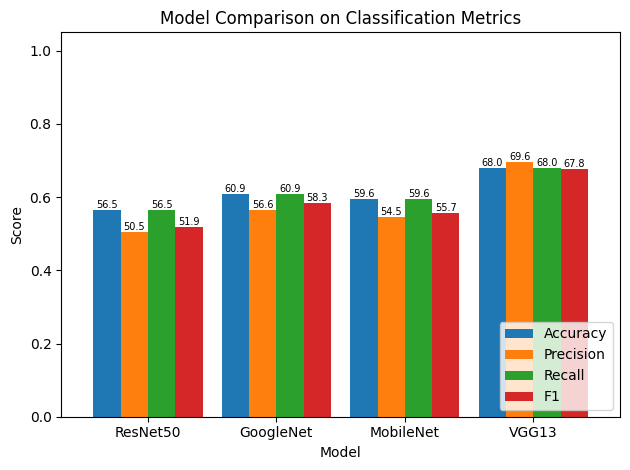

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
result = [
    {'Model': 'ResNet50', 'Accuracy': 0.5652, 'Precision': 0.5055, 'Recall': 0.5652, 'F1': 0.5188},
    {'Model': 'GoogleNet', 'Accuracy': 0.6087, 'Precision': 0.5659, 'Recall': 0.6087, 'F1': 0.5828},
    {'Model': 'MobileNet', 'Accuracy': 0.5957, 'Precision': 0.5452, 'Recall': 0.5957, 'F1': 0.5569},
    {'Model': 'VGG13', 'Accuracy': 0.6804, 'Precision': 0.6957, 'Recall': 0.6804, 'F1': 0.6780}
]


df_metrics = pd.DataFrame(result)
df_metrics.set_index("Model", inplace=True)

plt.figure(figsize=(10, 6))
ax = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', width=0.85)
plt.ylim(0, 1.05)
plt.title("Model Comparison on Classification Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()

# Add percentage labels to each bar, smaller font and one decimal
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.1f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=7, rotation=0)

plt.show()

In [ ]:
print()

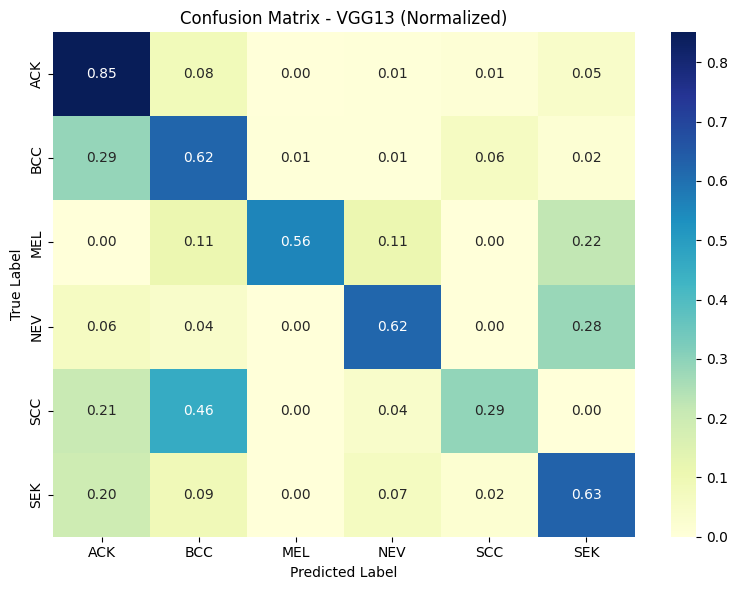

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use the same confusion matrix for VGG13 again
conf_matrix_vgg13 = np.array([
    [131, 13, 0, 1, 2, 7],
    [51, 110, 1, 1, 11, 3],
    [0, 1, 5, 1, 0, 2],
    [3, 2, 0, 31, 0, 14],
    [5, 11, 0, 1, 7, 0],
    [9, 4, 0, 3, 1, 29]
])

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_vgg13.astype('float') / conf_matrix_vgg13.sum(axis=1)[:, np.newaxis]

# Define class labels
labels = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

# Plot confusion matrix heatmap with better color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='YlGnBu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title("Confusion Matrix - VGG13 (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
